<a href="https://colab.research.google.com/github/TsvetaIvanova/ColabIMLO/blob/main/5_practical_IMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get and process data


# Test

#Get full dataset into dataframe


In [1]:
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
import time
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt


In [2]:
print(torch.__version__)
# !pip install torch==2.2.2

2.2.1+cu121


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [4]:
data_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(116),
    #transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1137, -0.1922, -0.3014], std=[1.0848, 0.9040, 0.9558]),
])




In [5]:
def show_image(dataset, index=0):
    image, label = dataset[index]
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.show()




In [6]:
train_set = datasets.Flowers102(root='data', split='train', download=True, transform=data_transform)
test_set = datasets.Flowers102(root='data', split='test', download=True, transform=data_transform)
val_set = datasets.Flowers102(root='data', split='val', download=True, transform=data_transform)


# create data loaders

train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=False)

# calculating mean and std to use in Normalize
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        image_count_in_batch = images.size(0)
        images = images.view(image_count_in_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_batch

    mean /= total_images_count
    std /= total_images_count

    return mean, std


mean, std = calculate_mean_std(train_loader)
print(f'Mean: {mean}\nStd: {std}')

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Mean: tensor([0.3392, 0.6465, 0.6513])
Std: tensor([0.2564, 0.2486, 0.2402])
Shape of X [N, C, H, W]: torch.Size([32, 3, 116, 116])
Shape of y: torch.Size([32]) torch.int64


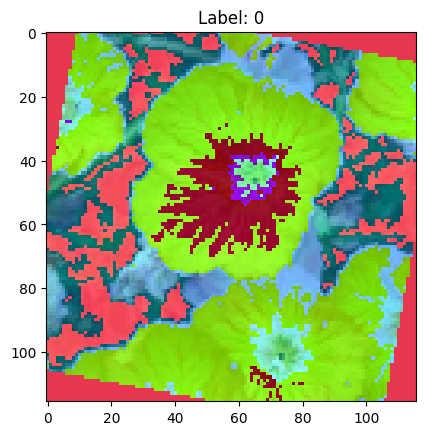

In [7]:
show_image(train_set)

## using the datasets.Flowers102 function

# preprocess data for training


# NN Architecture(Neural Network)


## define the model

In [8]:
class ConvNN(nn.Module):
    def __init__(self, hidden_units=128):
        super(ConvNN, self).__init__()
        self.hidden_units = hidden_units
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, hidden_units, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(hidden_units)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(hidden_units * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 102)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        # print(x.shape)
        x = x.view(-1, self.hidden_units * 14 * 14)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x






# class ConvNN(nn.Module):
#     # def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
#     #     super().__init__()
#     #     self.layer_stack = nn.Sequential(
#     #         nn.Flatten(), # neural networks like their inputs in vector form
#     #         nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
#     #         nn.Linear(in_features=hidden_units, out_features=output_shape)
#     #     )

#     # def forward(self, x):
#     #     return self.layer_stack(x)

#     def __init__(self, hidden_units=128):
#          super(ConvNN, self).__init__()
#          self.hidden_units=hidden_units
#          self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv3 = nn.Conv2d(64, hidden_units, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv4 = nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=1, bias=True)
#          self.bn1 = nn.BatchNorm2d(32)
#          self.bn2 = nn.BatchNorm2d(64)
#          self.bn3 = nn.BatchNorm2d(hidden_units)

#          self.pool = nn.MaxPool2d(2, 2, padding=0)
#          self.fc1 = nn.Linear(hidden_units * 14 * 14, 512)
#          self.fc2 = nn.Linear(512, 102)
#          # self.dropout1 = nn.Dropout(0.15)
#          self.dropout2 = nn.Dropout(0.5)




#         #x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         #x = self.pool(F.relu(self.bn2(self.conv2(x))))


#         #x = F.relu(self.fc1(x))
#         #
#         #x = self.fc2(x)
#         #return x
#         #x = self.flatten(x)
#         #logits = self.linear_relu_stack(x)
#         #return logits
#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         # x = F.relu(self.conv1(x))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         # x = F.relu(self.conv3(x))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = self.pool(F.relu((self.conv4(x))))
#         x = self.pool(F.relu((self.conv5(x))))
#         x = self.pool(F.relu((self.conv6(x))))
#         x = self.pool(F.relu((self.conv7(x))))
#         x = self.pool(F.relu((self.conv8(x))))
#         # x = self.pool(F.relu(self.conv2(x)))

#         # print(x.shape)
#         x = x.view(-1, self.hidden_units * 14 * 14) # Flatten the output for the dense layer
#         x = F.relu(self.fc1(x))
#         # x = self.dropout1(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return x





In [9]:
def train(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 10 == 0:
            print(f'Epoch {t+1}, Batch {batch}, Loss: {loss.item():.4f}')

        # Time each batch processing
        if batch == 0:
            start_time = time.time()
        elif batch == 1:
            elapsed_time = time.time() - start_time
            print(f"Time per batch: {elapsed_time:.2f} seconds")

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss:.4f}')

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
model = ConvNN(hidden_units=128).to(device)
print(model)

# LossFN
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  # Lower learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



ConvNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)


# Train and Evaluation


In [12]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    if t > 20:
      test(val_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Epoch 1, Batch 0, Loss: 4.6488
Time per batch: 0.82 seconds
Epoch 1, Batch 10, Loss: 4.5740
Epoch 1, Batch 20, Loss: 4.6689
Epoch 1, Batch 30, Loss: 4.6768
Epoch 1, Batch 40, Loss: 4.6118
Epoch 1, Batch 50, Loss: 4.6190
Epoch 1, Batch 60, Loss: 4.6271
Average Loss: 4.6249
Epoch 2
-------------------------------
Epoch 2, Batch 0, Loss: 4.5796
Time per batch: 0.78 seconds
Epoch 2, Batch 10, Loss: 4.5688
Epoch 2, Batch 20, Loss: 4.3770
Epoch 2, Batch 30, Loss: 4.5472
Epoch 2, Batch 40, Loss: 4.4372
Epoch 2, Batch 50, Loss: 4.4455
Epoch 2, Batch 60, Loss: 4.2598
Average Loss: 4.4385
Epoch 3
-------------------------------
Epoch 3, Batch 0, Loss: 4.3645
Time per batch: 0.84 seconds
Epoch 3, Batch 10, Loss: 4.2688
Epoch 3, Batch 20, Loss: 4.1932
Epoch 3, Batch 30, Loss: 3.9402
Epoch 3, Batch 40, Loss: 4.1640
Epoch 3, Batch 50, Loss: 4.3390
Epoch 3, Batch 60, Loss: 4.5755
Average Loss: 4.1773
Epoch 4
-------------------------------
Epoch 4, Batch 0, Los

## split and format the dataset

## Create a checkpoint for the training and testing in case I have to pause

## Create a visualisation

In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [14]:
model = ConvNN().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## Set training parameters

## train

# Eval

In [15]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')


Accuracy of the network on the test images: 37.12798829077899 %
